In [2]:
!pip3 install pandas numpy opencv-python matplotlib scipy requests openpyxl
!pip3 install cv2	


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\Hp 15\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\Hp 15\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks

In [ ]:
# Load the video
video_path = '100_waheeda_1.mp4'
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Determine block size for 10x10 grid
block_width = width // 10
block_height = height // 10

# Initialize a list to hold the average red values for each block
avg_red_values = np.zeros((10, 10, frame_count), dtype=float)

current_frame = 0

while cap.isOpened() and current_frame < frame_count:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to RGB (if not already in RGB format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process each block
    for i in range(10):
        for j in range(10):
            # Define the current block
            block = frame_rgb[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            
            # Calculate the average red value for the block
            avg_red = np.mean(block[:, :, 0])  # 0 index for the red channel
            avg_red_values[i, j, current_frame] = avg_red
            
    current_frame += 1

# Close video file
cap.release()

# Selecting frames 51 to 550 due to noise at the start and end of the video
selected_frames = avg_red_values[:, :, 26:276]
selected_frames


array([[[253.60382909, 253.60990548, 253.60908565, ..., 253.63589892,
         253.63392168, 253.64742477],
        [253.35619213, 253.35619213, 253.34153164, ..., 253.61911651,
         253.60966435, 253.68185764],
        [253.48302469, 253.48302469, 253.46412037, ..., 254.08805941,
         254.06621335, 254.13855131],
        ...,
        [253.69376929, 253.69521605, 253.70780285, ..., 253.93475116,
         253.9220679 , 253.97284915],
        [253.43364198, 253.43364198, 253.43364198, ..., 251.09919946,
         251.10908565, 251.36839313],
        [253.12162423, 253.0226659 , 252.83887924, ..., 246.28641011,
         246.28645833, 246.37369792]],

       [[253.59534144, 253.58945795, 253.57826968, ..., 253.73635224,
         253.71966628, 253.7297936 ],
        [253.48490548, 253.48490548, 253.47299383, ..., 254.13083526,
         254.11115934, 254.14737654],
        [254.17824074, 254.1804591 , 254.13425926, ..., 253.82262731,
         253.82204861, 253.82122878],
        ...,


In [ ]:
frame_count

300

In [ ]:
avg_red_values.shape

(10, 10, 300)

In [ ]:
selected_frames.shape

(10, 10, 250)

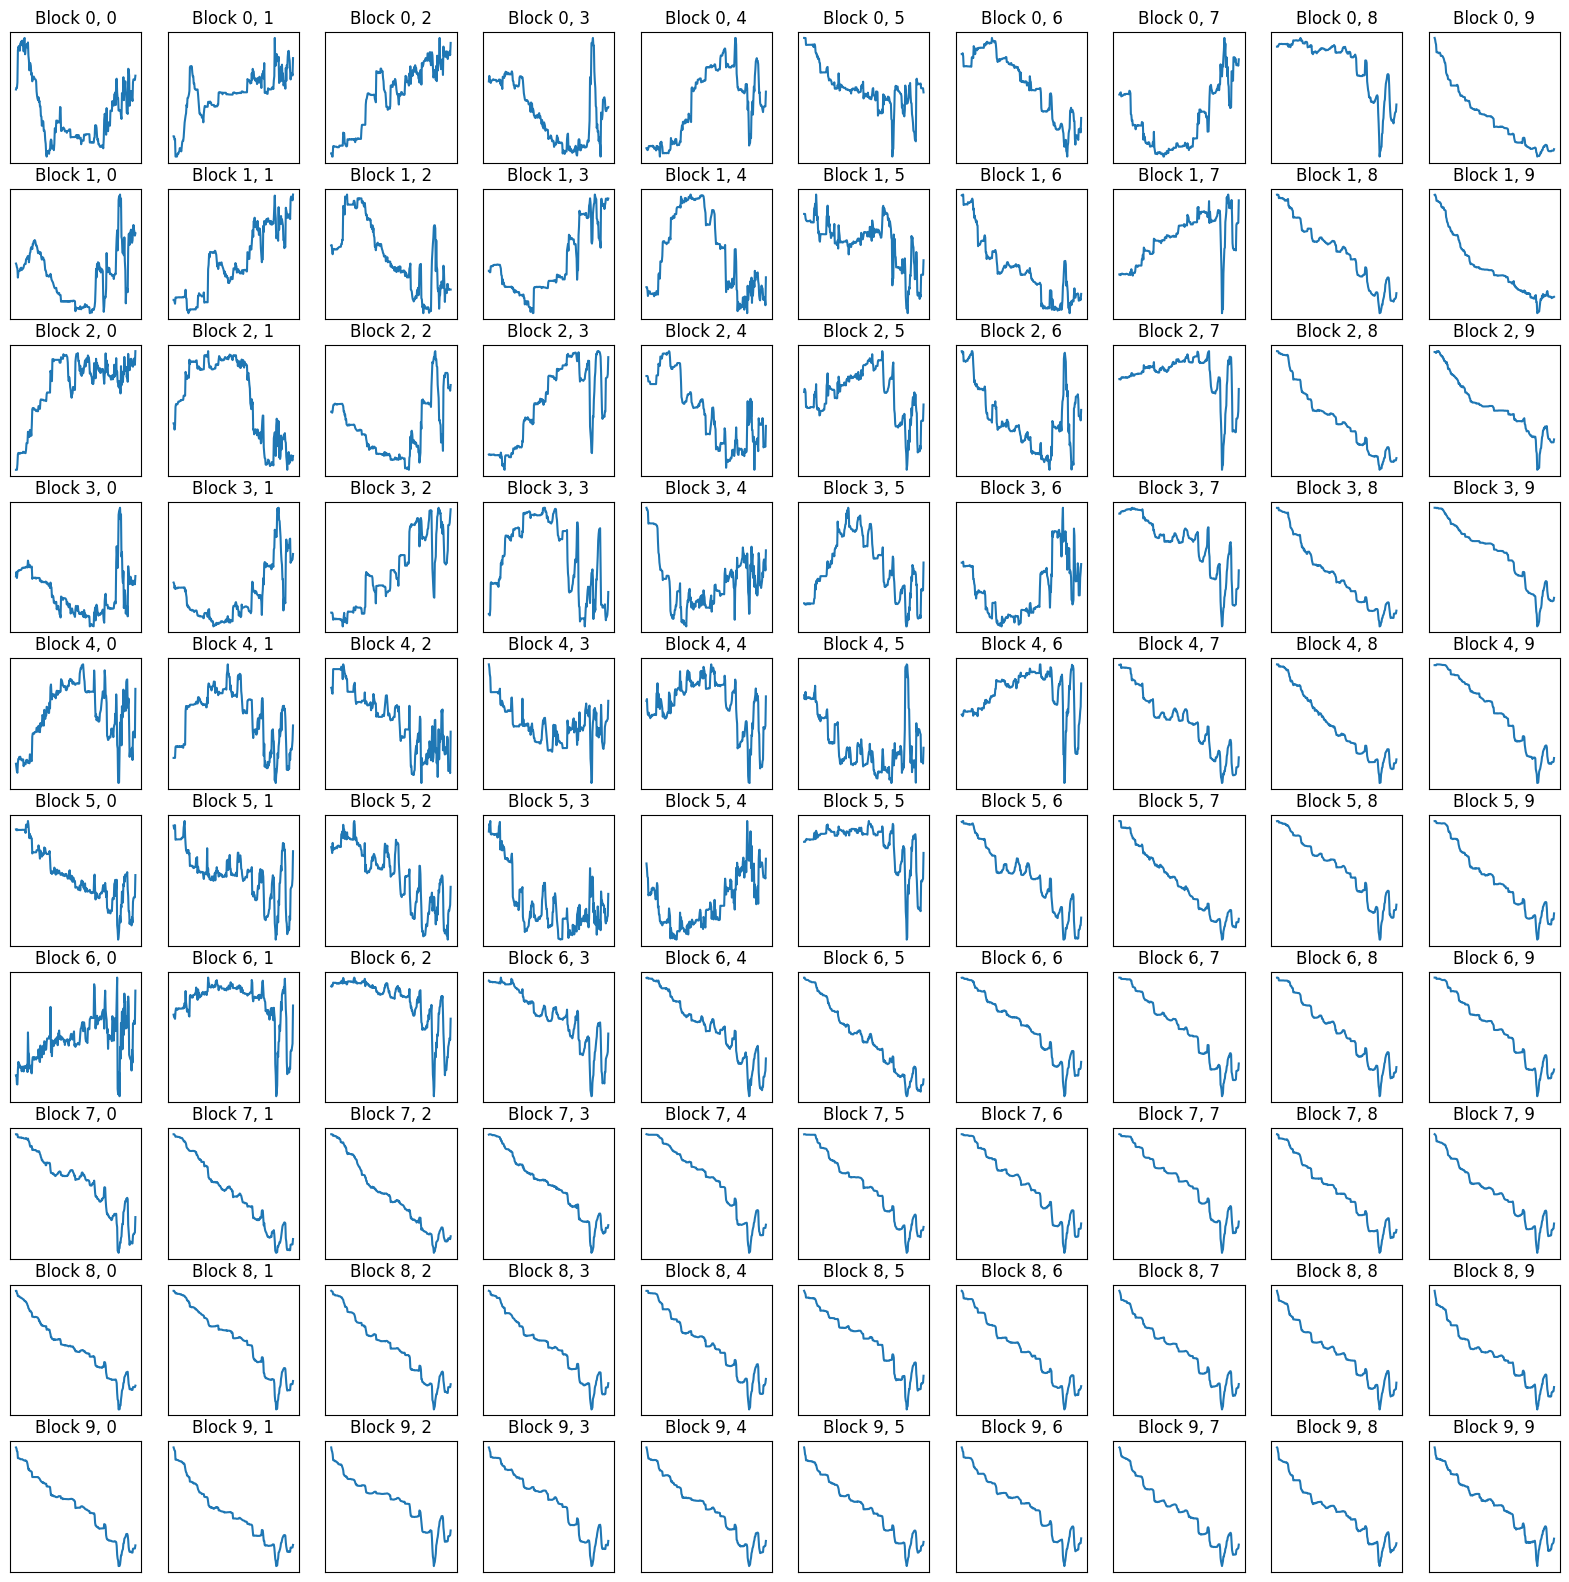

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(selected_frames[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()



In [ ]:
Su = selected_frames

In [ ]:
# Define functions for Butterworth filter and FFT
def butterworth_filter(signal, sampling_rate, lowcut, highcut, order=2):
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def apply_fft(signal, sampling_rate, low_freq=0.5, high_freq=5.0):
    n = len(signal)
    freq = fftfreq(n, d=1/sampling_rate)
    fft_signal = fft(signal)

    # Identify indices corresponding to frequencies outside the desired range
    unwanted_indices = (freq < low_freq) | (freq > high_freq)
        
    # Set those frequency components to zero
    fft_signal[unwanted_indices] = 0
        
    # Apply inverse FFT to get the filtered signal
    filtered_signal = ifft(fft_signal)
    return filtered_signal.real


# Parameters for Butterworth filter
lowcut = 0.5  # Hz
highcut = 5.0  # Hz
sampling_rate = fps

# Apply Butterworth filter to each PPG signal
Sc = np.zeros_like(Su)
BF = np.zeros_like(Su)
for i in range(10):
    for j in range(10):
        signal = Su[i, j, :]
        filtered_signal = butterworth_filter(signal, sampling_rate, lowcut, highcut)
        BF[i, j, :] = filtered_signal
        fft_signal = apply_fft(filtered_signal, sampling_rate, lowcut, highcut)
        Sc[i, j, :] = fft_signal

#multiplying Sc with -1 to get SPPG
SPPG = -1 * Sc


In [ ]:
SPPG.shape

(10, 10, 250)

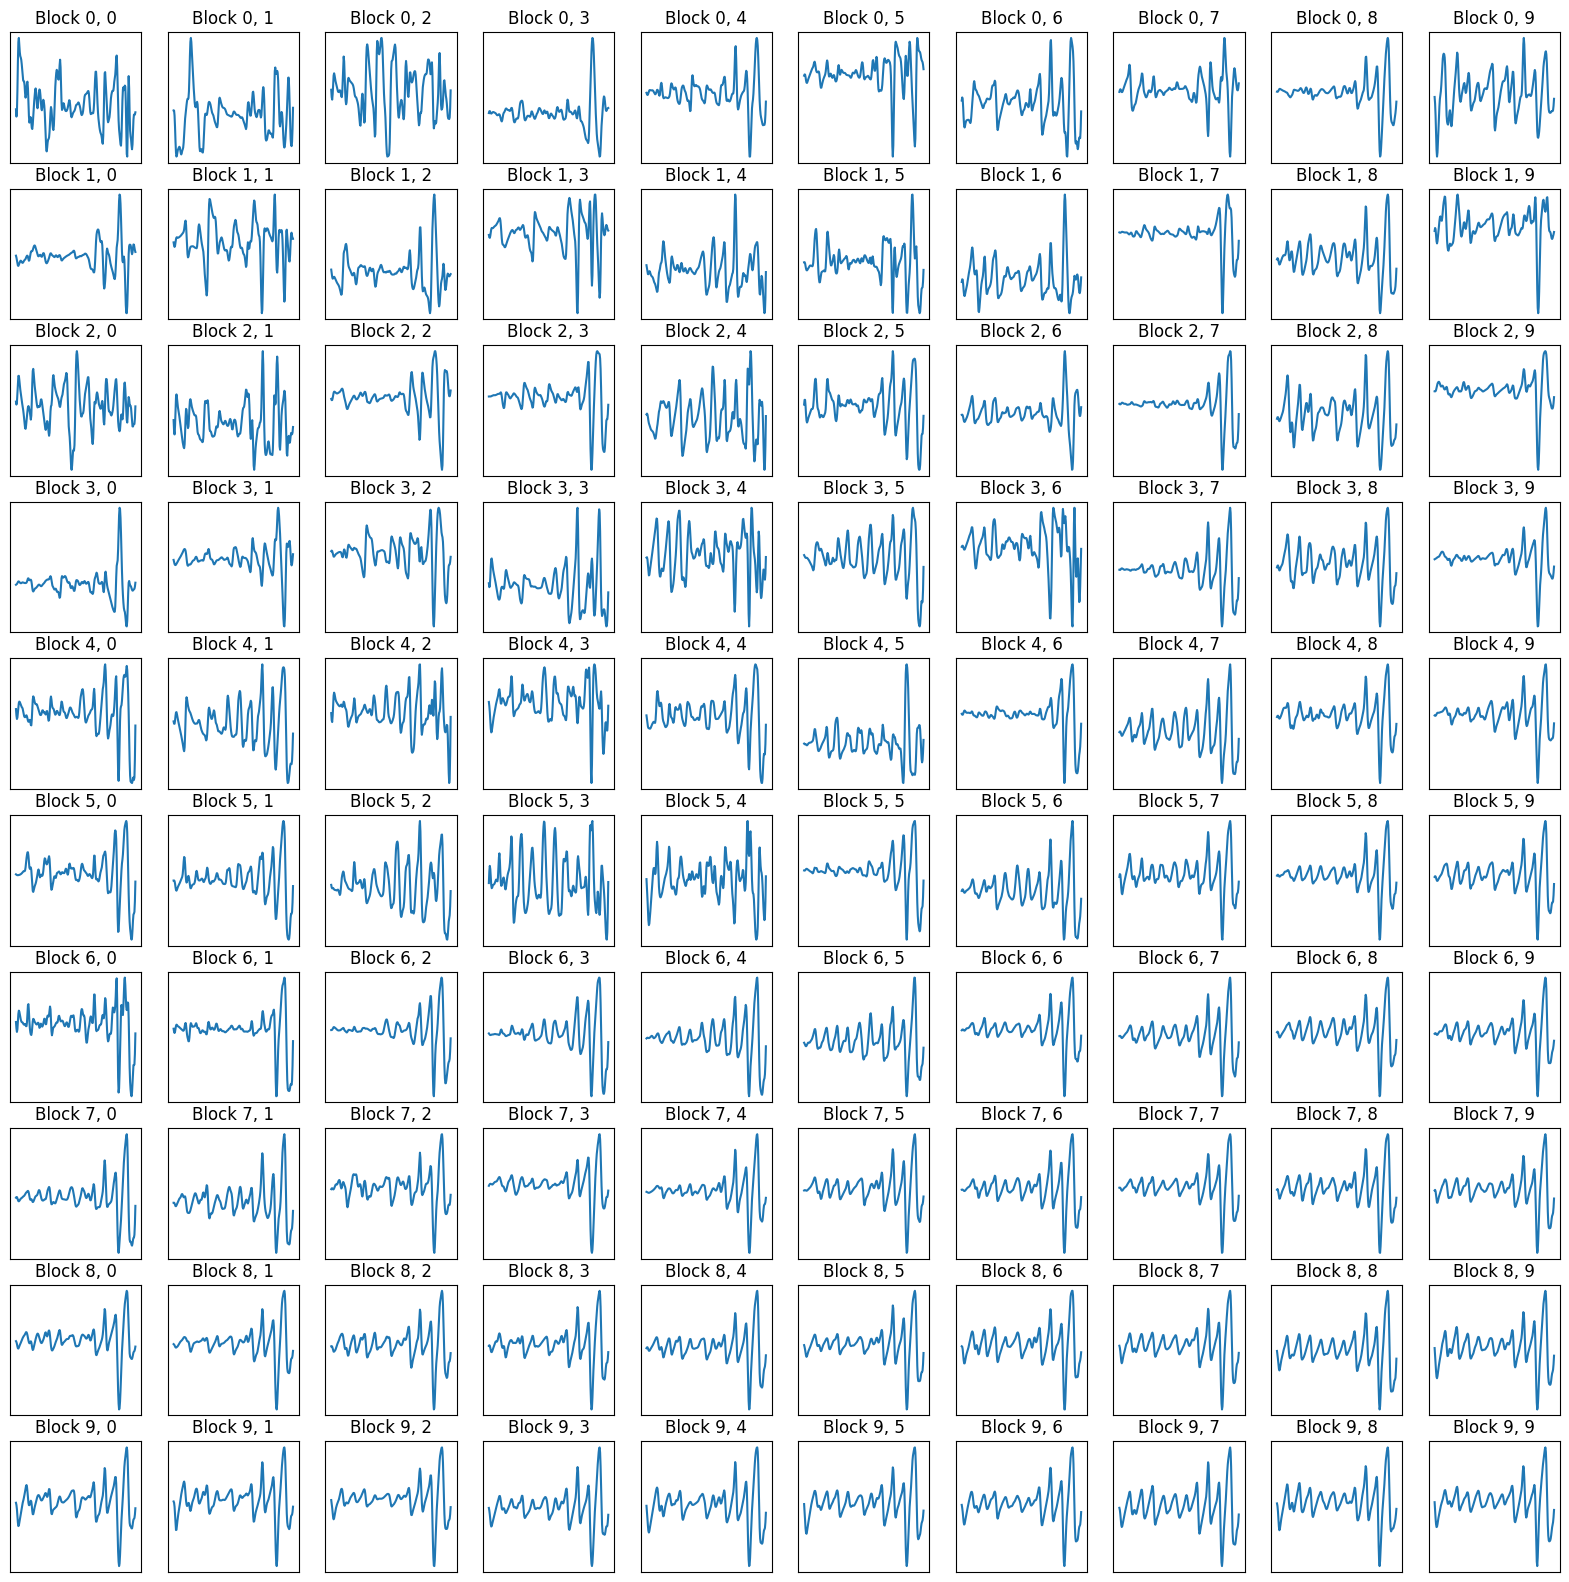

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(BF[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()



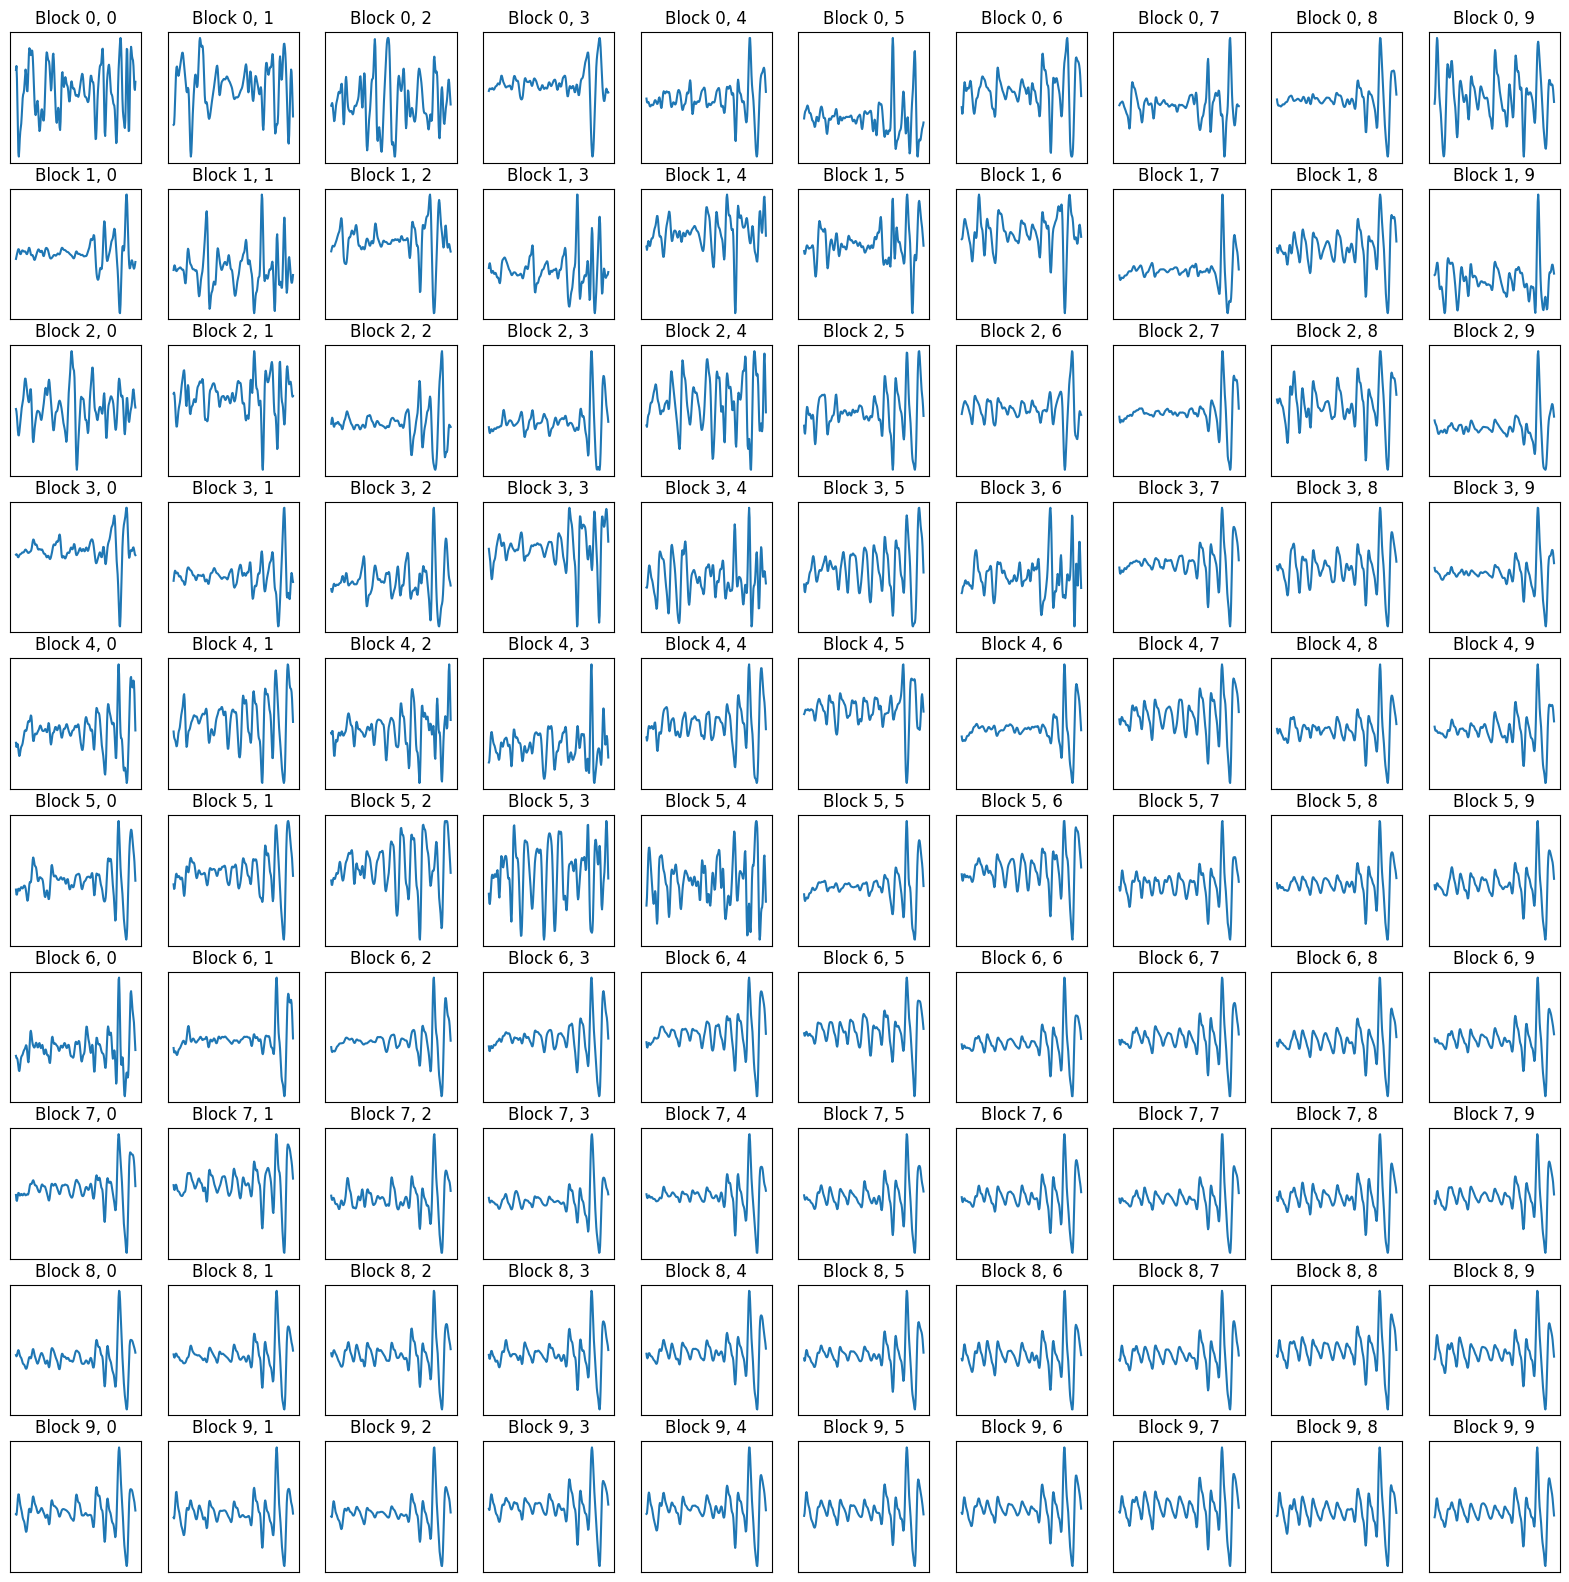

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(SPPG[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()

In [ ]:
# Create a list to hold the average red values for the first block of each frame
first_block_avg_red = []
# Iterate through each frame
for i in range(Su.shape[2]):
    # Extract the average red value for the first block of the current frame
    avg_red = Su[0, 0, i]
    # Append the average red value to the list
    first_block_avg_red.append(avg_red)


# Create a list to hold the average red values for the first block of each frame
first_block_denoised = []
# Iterate through each frame
for i in range(SPPG.shape[2]):
    # Extract the average red value for the first block of the current frame
    avg_red_d = SPPG[0, 0, i]
    # Append the average red value to the list
    first_block_denoised.append(avg_red_d)



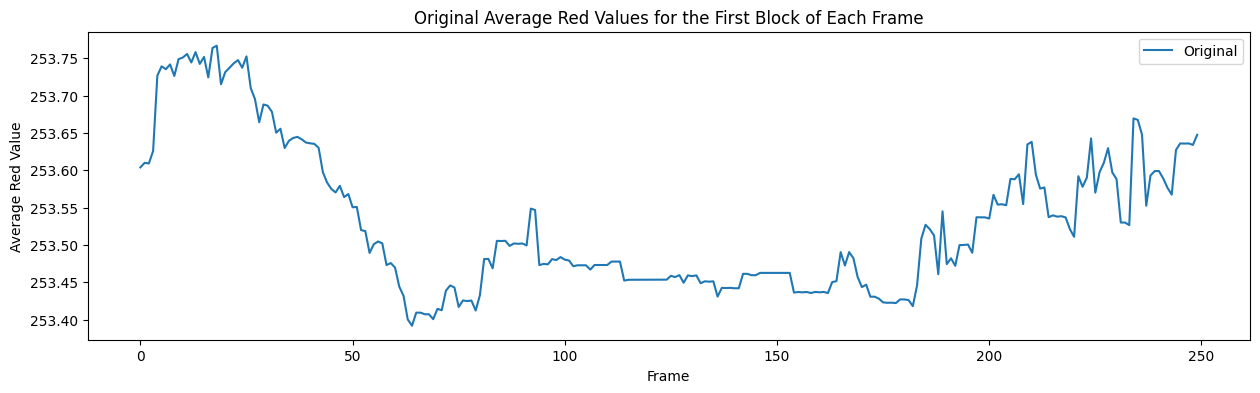

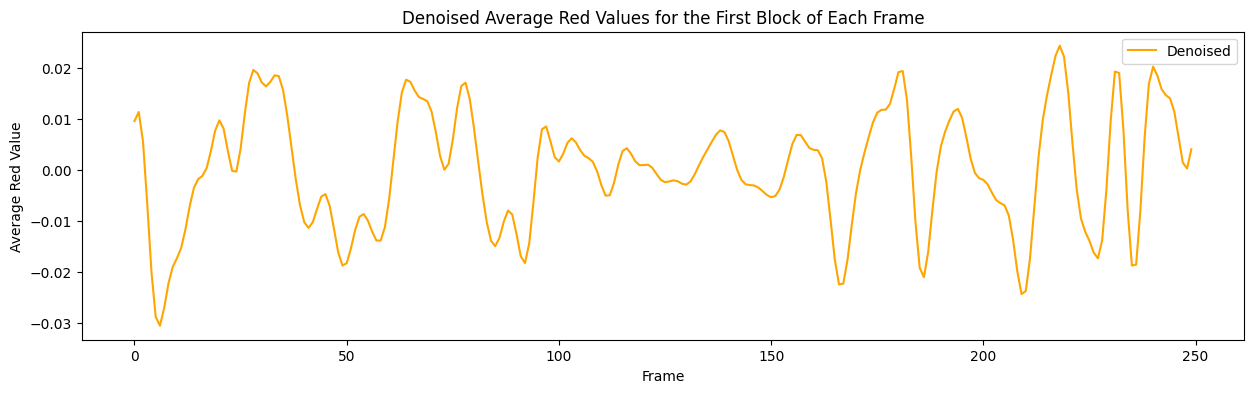

In [ ]:
# Plot first_block_avg_red
plt.figure(figsize=(15, 4))
plt.plot(first_block_avg_red, label='Original')
plt.xlabel('Frame')
plt.ylabel('Average Red Value')
plt.title('Original Average Red Values for the First Block of Each Frame')
plt.legend()
plt.show()

# Plot first_block_denoised
plt.figure(figsize=(15, 4))
plt.plot(first_block_denoised, color='orange', label='Denoised')
plt.xlabel('Frame')
plt.ylabel('Average Red Value')
plt.title('Denoised Average Red Values for the First Block of Each Frame')
plt.legend()
plt.show()


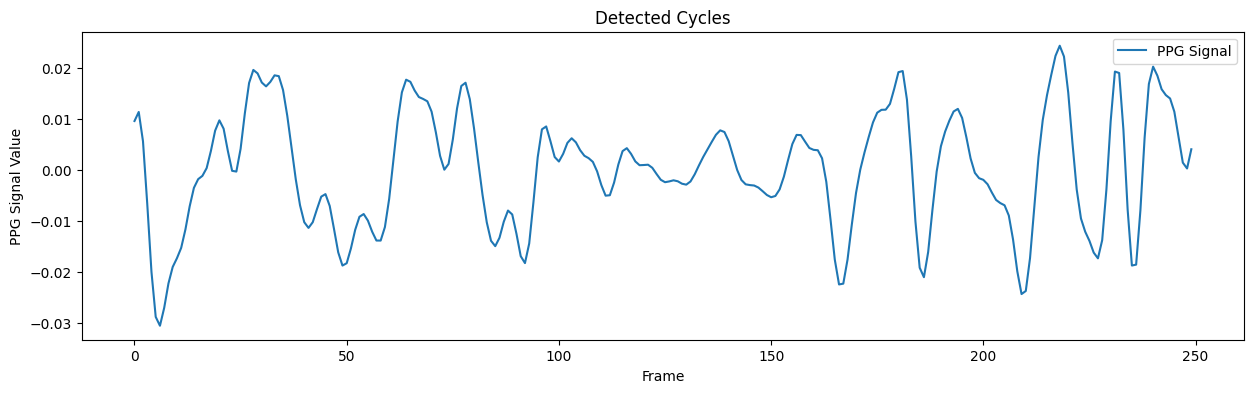

Detected PPG cycles: []


In [ ]:
def get_expected_cycle_time(ppg_signal, sampling_rate):
    # Compute the FFT of the PPG signal
    fft_signal = fft(ppg_signal)
    
    # Compute the frequency spectrum and corresponding frequencies
    n = len(ppg_signal)
    freq = fftfreq(n, d=1/sampling_rate)
    
    # Find the index of the dominant frequency component
    dominant_freq_idx = np.argmax(np.abs(fft_signal))
    
    # Calculate the period of the dominant frequency component
    dominant_freq = freq[dominant_freq_idx]
    if dominant_freq == 0:
        # Avoid division by zero when the dominant frequency is 0 Hz
        return np.inf
    expected_period = 1 / dominant_freq
    
    # Convert period to cycle time (in seconds)
    expected_cycle_time = expected_period
    
    return expected_cycle_time


def detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate):
    ppg_cycles = []

    peaks, _ = find_peaks(sppg_signal)
    valleys, _ = find_peaks(-sppg_signal)

    # Ensure peaks and valleys are not empty
    if len(peaks) == 0 or len(valleys) == 0:
        return ppg_cycles

    # Plot the PPG signal
    plt.figure(figsize=(15,4))
    plt.plot(sppg_signal, label='PPG Signal')

    # # Mark peaks and valleys differently
    # plt.scatter(peaks, sppg_signal[peaks], color='red', marker='o', label='Peaks')
    # plt.scatter(valleys, sppg_signal[valleys], color='blue', marker='x', label='Valleys')

    # Mark start_point, systolic_peak, dicrotic_notch, diastolic_peak, and end_point
    for peak_idx in range(len(peaks) - 1):
        for valley_idx in range(len(valleys) - 1):
            start_idx = valleys[valley_idx]
            end_idx = valleys[valley_idx + 1]

            # Check if the current peak is within the current valley
            if start_idx < peaks[peak_idx] < end_idx:
                systolic_peak = peaks[peak_idx]
                diastolic_peak = peaks[peak_idx + 1]
                start_point = start_idx
                end_point = valleys[valley_idx + 2]
                dicrotic_notch = valleys[valley_idx+1]

                # Check conditions for valid PPG cycle
                if (sppg_signal[systolic_peak] > sppg_signal[diastolic_peak]):
                    if (sppg_signal[dicrotic_notch] > sppg_signal[start_point] and sppg_signal[dicrotic_notch] > sppg_signal[end_point]):

                        # Calculate time elapsed for PPG cycle
                        cycle_time = (end_point - start_point) / sampling_rate
                        expected_cycle_time = get_expected_cycle_time(sppg_signal, sampling_rate)
                        error_margin = 0.2 * expected_cycle_time
                        # Check if time elapsed is within threshold
                        if abs(cycle_time - expected_cycle_time) <= error_margin:
                            
                            # Mark each systolic peak and diastolic peak with a different marker
                            plt.scatter(systolic_peak, sppg_signal[systolic_peak], color='green', marker='^')
                            plt.scatter(diastolic_peak, sppg_signal[diastolic_peak], color='pink', marker='d')
                            # Mark each dicrotic notch with a different marker
                            plt.scatter(dicrotic_notch, sppg_signal[dicrotic_notch], color='purple', marker='*')
                            ppg_cycles.append((start_point, systolic_peak, dicrotic_notch, diastolic_peak, end_point))
                            # Mark starting and ending point with a different marker
                            plt.scatter(start_point, sppg_signal[start_point], color='black', marker='P')
                            plt.scatter(end_point, sppg_signal[end_point], color='orange', marker='s')

    # Plot the legend
    plt.legend()
    plt.legend(['PPG Signal', 'Systolic Peak', 'Diastolic Peak', 'Dicrotic Notch', 'Start Point', 'End Point'])
    plt.xlabel('Frame')
    plt.ylabel('PPG Signal Value')
    plt.title('Detected Cycles')
    plt.show()

    return ppg_cycles

# Example usage
sampling_rate = fps 
sppg_signal = SPPG[0, 0, :]  # Assuming we are processing the first PPG signal
ppg_cycles = detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate)
print("Detected PPG cycles:", ppg_cycles)


In [ ]:
def detect_ppg_cycles_for_each_signal(SPPG, sampling_rate):
    all_ppg_cycles = []

    for i in range(10):
        for j in range(10):
            ppg_signal = SPPG[i, j, :]
            ppg_cycles = detect_ppg_cycles(ppg_signal, sampling_rate)
            all_ppg_cycles.extend(ppg_cycles)

    return all_ppg_cycles

# Example usage
sampling_rate = 30  # Sample rate in Hz (assumed)
all_ppg_cycles = detect_ppg_cycles_for_each_signal(SPPG, sampling_rate)
print("Detected PPG cycles:", all_ppg_cycles)

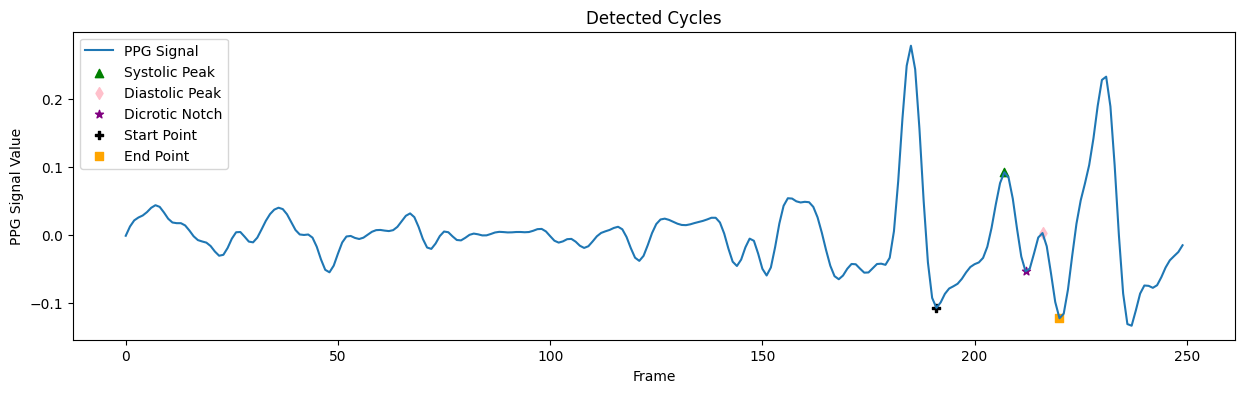

Detected PPG cycles: [(191, 207, 212, 216, 220)]


In [ ]:
def get_expected_cycle_time(ppg_signal, sampling_rate):
    # Compute the FFT of the PPG signal
    fft_signal = fft(ppg_signal)
    
    # Compute the frequency spectrum and corresponding frequencies
    n = len(ppg_signal)
    freq = fftfreq(n, d=1/sampling_rate)
    
    # Find the index of the dominant frequency component
    dominant_freq_idx = np.argmax(np.abs(fft_signal))
    
    # Calculate the period of the dominant frequency component
    dominant_freq = freq[dominant_freq_idx]
    if dominant_freq != 0:
        # Avoid division by zero when the dominant frequency is 0 Hz
        expected_period = 1 / dominant_freq
    else:
        return np.inf
    
    # Convert period to cycle time (in seconds)
    expected_cycle_time = expected_period
    
    return expected_cycle_time


def detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate):
    ppg_cycles = []

    peaks, _ = find_peaks(sppg_signal)
    valleys, _ = find_peaks(-sppg_signal)

    # Ensure peaks and valleys are not empty
    if len(peaks) == 0 or len(valleys) == 0:
        return ppg_cycles

    # Plot the PPG signal
    plt.figure(figsize=(15,4))
    plt.plot(sppg_signal, label='PPG Signal')

    # Mark start_point, systolic_peak, dicrotic_notch, diastolic_peak, and end_point
    for peak_idx in range(len(peaks) - 1):
        for valley_idx in range(len(valleys) - 1):
            start_idx = valleys[valley_idx]
            end_idx = valleys[valley_idx + 1]

            # Check if the current peak is within the current valley
            if start_idx < peaks[peak_idx] < end_idx:
                systolic_peak = peaks[peak_idx]
                diastolic_peak = peaks[peak_idx + 1]
                start_point = start_idx
                end_point = valleys[valley_idx + 2]
                dicrotic_notch = valleys[valley_idx+1]

                # Check conditions for valid PPG cycle
                if (sppg_signal[systolic_peak] > sppg_signal[diastolic_peak]):
                    if (sppg_signal[dicrotic_notch] > sppg_signal[start_point] and sppg_signal[dicrotic_notch] > sppg_signal[end_point]):

                        # Calculate time elapsed for PPG cycle
                        cycle_time = (end_point - start_point) / sampling_rate
                        expected_cycle_time = get_expected_cycle_time(sppg_signal, sampling_rate)
                        error_margin = 0.2 * expected_cycle_time
                        
                        # Check if time elapsed is within threshold
                        if abs(cycle_time - expected_cycle_time) <= error_margin:
                            # Mark each systolic peak and diastolic peak with a different marker
                            plt.scatter(systolic_peak, sppg_signal[systolic_peak], color='green', marker='^')
                            plt.scatter(diastolic_peak, sppg_signal[diastolic_peak], color='pink', marker='d')
                            # Mark each dicrotic notch with a different marker
                            plt.scatter(dicrotic_notch, sppg_signal[dicrotic_notch], color='purple', marker='*')
                            ppg_cycles.append((start_point, systolic_peak, dicrotic_notch, diastolic_peak, end_point))
                            # Mark starting and ending point with a different marker
                            plt.scatter(start_point, sppg_signal[start_point], color='black', marker='P')
                            plt.scatter(end_point, sppg_signal[end_point], color='orange', marker='s')

    # Plot the legend
    plt.legend()
    plt.legend(['PPG Signal', 'Systolic Peak', 'Diastolic Peak', 'Dicrotic Notch', 'Start Point', 'End Point'])
    plt.xlabel('Frame')
    plt.ylabel('PPG Signal Value')
    plt.title('Detected Cycles')
    plt.show()

    return ppg_cycles


# Example usage
sampling_rate = fps 
sppg_signal = SPPG[0, 5, :]  # Assuming we are processing the first PPG signal
ppg_cycles = detect_ppg_cycles_for_one_signal(sppg_signal, sampling_rate)
print("Detected PPG cycles:", ppg_cycles)


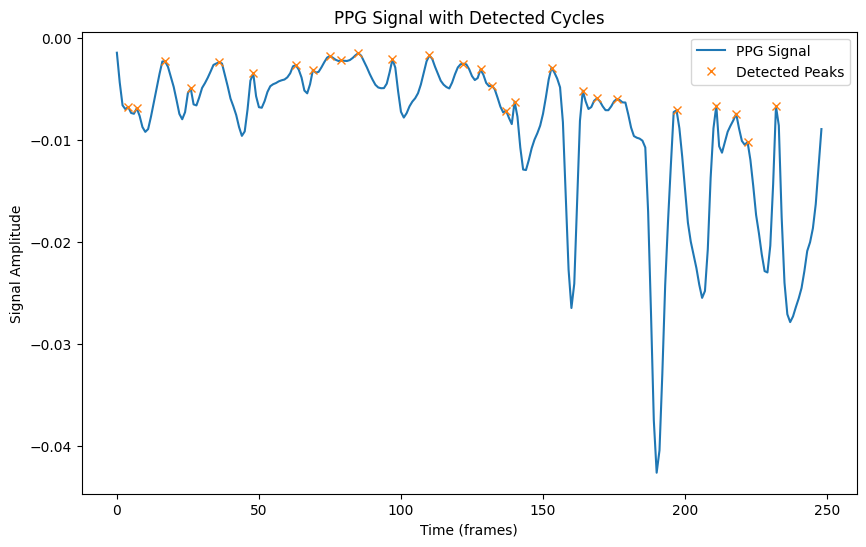

Time between peaks (seconds): [0.1        0.33333333 0.3        0.33333333 0.4        0.5
 0.2        0.2        0.13333333 0.2        0.4        0.43333333
 0.4        0.2        0.13333333 0.16666667 0.1        0.43333333
 0.36666667 0.16666667 0.23333333 0.7        0.46666667 0.23333333
 0.13333333 0.33333333]


In [ ]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_signal is your 1D PPG signal obtained from the previous steps
signal = avg_signal  # This is the averaged PPG signal across all blocks

# Detect peaks (systolic points) in the PPG signal
peaks, _ = find_peaks(signal, height=None)  # Adjust the height parameter as needed to filter peaks

# Plot the signal and mark the peaks
plt.figure(figsize=(10, 6))
plt.plot(signal, label='PPG Signal')
plt.plot(peaks, signal[peaks], "x", label='Detected Peaks')  # Mark the detected peaks
plt.title('PPG Signal with Detected Cycles')
plt.xlabel('Time (frames)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.show()

# Calculate the duration of each PPG cycle (assuming a constant frame rate)
frame_rate = fps  # Frames per second, as defined previously
time_between_peaks = np.diff(peaks) / frame_rate  # Time in seconds between peaks

# Output the time between peaks to understand the cycle duration
print("Time between peaks (seconds):", time_between_peaks)


Invalid heartbeat frequency detected.
Cycle Time: 7.166666666666667, Heartbeat Time: inf, Difference: nan
Cycle Time: 6.766666666666667, Heartbeat Time: inf, Difference: nan
Cycle Time: 6.1, Heartbeat Time: inf, Difference: nan
Cycle Time: 5.4, Heartbeat Time: inf, Difference: nan
Cycle Time: 4.3, Heartbeat Time: inf, Difference: nan
Cycle Time: 3.8333333333333335, Heartbeat Time: inf, Difference: nan
Cycle Time: 3.1, Heartbeat Time: inf, Difference: nan
Cycle Time: 2.466666666666667, Heartbeat Time: inf, Difference: nan
Cycle Time: 2.033333333333333, Heartbeat Time: inf, Difference: nan
Cycle Time: 1.8333333333333333, Heartbeat Time: inf, Difference: nan
Cycle Time: 1.2666666666666666, Heartbeat Time: inf, Difference: nan
Cycle Time: 0.8333333333333334, Heartbeat Time: inf, Difference: nan
Cycle Time: 0.0, Heartbeat Time: inf, Difference: nan
Cycle Time: -0.8333333333333334, Heartbeat Time: inf, Difference: nan
Cycle Time: -1.2666666666666666, Heartbeat Time: inf, Difference: nan
Cycl

/tmp/ipykernel_37674/1435442399.py:47: RuntimeWarning: invalid value encountered in scalar divide
  if abs(cycle_time - heartbeat_time) / heartbeat_time <= 0.2:  # Within 20% of expected cycle time
/tmp/ipykernel_37674/1435442399.py:50: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Cycle Time: {cycle_time}, Heartbeat Time: {heartbeat_time}, Difference: {abs(cycle_time - heartbeat_time) / heartbeat_time}")


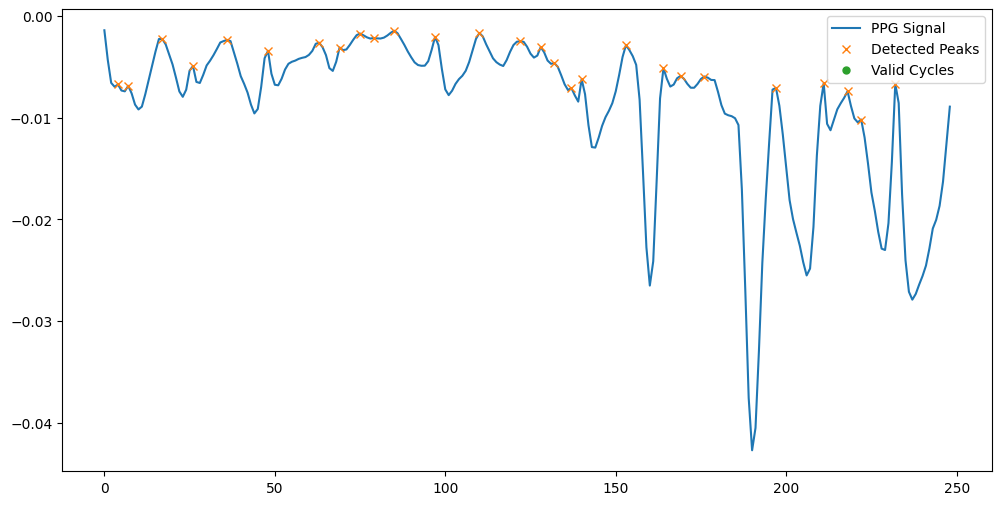

In [ ]:
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fftpack import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# SPG: Your processed PPG signal

# Helper function to find troughs
def find_troughs(signal):
    return find_peaks(-signal)[0]

# Step 1: Detect all peaks and troughs
peaks, _ = find_peaks(avg_signal)
troughs = find_troughs(avg_signal)

# FFT to find dominant frequency (for timing constraints)
def find_heartbeat_frequency(signal, fs):
    """Estimate the heart beat frequency from PPG signal using FFT."""
    yf = fft(signal)
    xf = fftfreq(len(signal), 1 / fs)
    idx = np.argmax(np.abs(yf))
    return np.abs(xf[idx])

# Estimate the heartbeat frequency
heartbeat_freq = find_heartbeat_frequency(avg_signal, fps)
# Convert frequency to time (s) for one cycle (heartbeat duration)
if heartbeat_freq > 0:
    heartbeat_time = 1 / heartbeat_freq
else:
    print("Invalid heartbeat frequency detected.")
    # Handle the 
# heartbeat_time = 1 / heartbeat_freq

# Step 2: Apply criteria to filter valid PPG cycles
valid_cycles = []
for i in range(1, len(peaks) - 1):
    peak = peaks[i]
    prev_trough = troughs[np.argmax(troughs[troughs < peak])]  # Previous trough
    next_trough = troughs[np.argmax(troughs[troughs > peak])]  # Next trough
    
    # Criteria checks (simplified for demonstration)
    # Implement specific logic to verify systolic > diastolic peak height,
    # and dicrotic notch height > start/end point height
    
    # Step 4: Time constraint (simplified check)
    cycle_time = (next_trough - prev_trough) / fps
    if abs(cycle_time - heartbeat_time) / heartbeat_time <= 0.2:  # Within 20% of expected cycle time
        valid_cycles.append(peak)
    # Inside the for loop for validating PPG cycles
    print(f"Cycle Time: {cycle_time}, Heartbeat Time: {heartbeat_time}, Difference: {abs(cycle_time - heartbeat_time) / heartbeat_time}")
    

# Corrected plotting for verification
plt.figure(figsize=(12, 6))
plt.plot(avg_signal, label='PPG Signal')  # Use avg_signal for plotting the signal
plt.plot(peaks, avg_signal[peaks], "x", label='Detected Peaks')  # Corrected to use avg_signal for peak plotting
plt.plot(valid_cycles, avg_signal[valid_cycles], "o", label='Valid Cycles', markersize=5)  # Corrected to use avg_signal for valid cycles plotting
plt.legend()
plt.show()



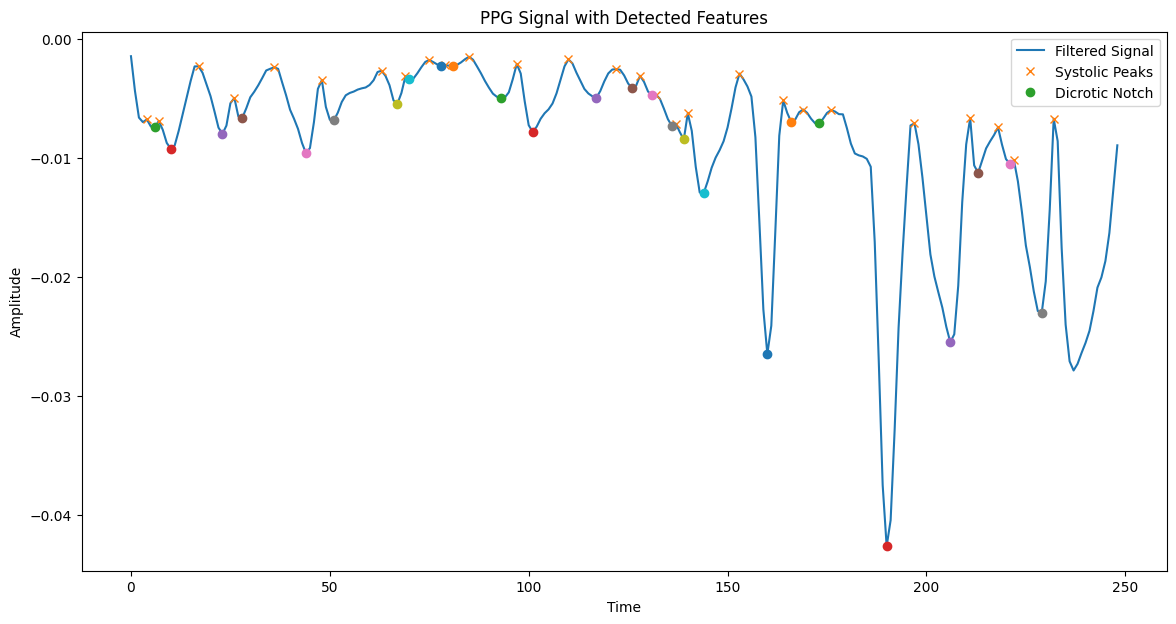

In [ ]:
# Step 2: Detect peaks and troughs
filtered_signal=avg_signal
peaks, _ = find_peaks(filtered_signal)
troughs = find_troughs(filtered_signal)

# Step 3: Analyze each peak to identify valid cycles
valid_cycles = []
for i, peak in enumerate(peaks[:-1]):
    # Find the next peak to estimate the cycle's end
    next_peak = peaks[i + 1]
    
    # Identify the troughs that could represent the dicrotic notch between the current and next peak
    potential_notches = troughs[(troughs > peak) & (troughs < next_peak)]
    
    if len(potential_notches) > 0:
        # Simplified assumption: The first trough after the peak is the dicrotic notch
        dicrotic_notch = potential_notches[0]
        valid_cycles.append((peak, dicrotic_notch))
    else:
        # If no notches are found, this may not be a valid cycle
        continue

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(filtered_signal, label='Filtered Signal')
plt.plot(peaks, filtered_signal[peaks], "x", label='Systolic Peaks')
for cycle in valid_cycles:
    plt.plot(cycle[1], filtered_signal[cycle[1]], "o", label='Dicrotic Notch' if cycle == valid_cycles[0] else "")

plt.legend()
plt.title('PPG Signal with Detected Features')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

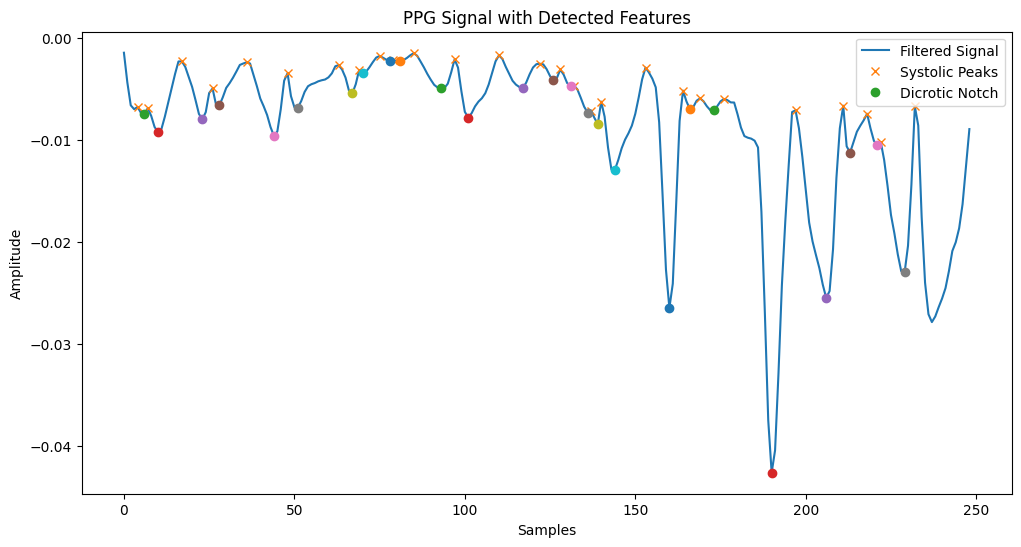

In [ ]:
def find_dicrotic_notch(troughs, peak, next_peak):
    # The dicrotic notch is typically found after the systolic peak and before the next peak.
    # This function will return the trough that is closest to the peak but not after the next peak.
    potential_notches = [trough for trough in troughs if peak < trough < next_peak]
    if potential_notches:
        # Assuming the dicrotic notch is the first trough after the systolic peak
        return potential_notches[0]
    return None

def is_valid_notch(notch, peak, next_peak, signal):
    # A valid notch should be lower than the peak (systolic) and higher than the following peak (next systolic).
    if notch and peak < notch < next_peak and signal[notch] < signal[peak]:
        return True
    return False

# Now, to use these functions to filter valid PPG cycles:
valid_cycles = []
for i in range(len(peaks) - 1):
    peak = peaks[i]
    next_peak = peaks[i + 1]
    notch = find_dicrotic_notch(troughs, peak, next_peak)
    
    if is_valid_notch(notch, peak, next_peak, avg_signal):
        valid_cycles.append((peak, notch))

# Assuming avg_signal is your filtered PPG signal, and peaks and troughs have been detected
plt.figure(figsize=(12, 6))
plt.plot(avg_signal, label='Filtered Signal')

# Plot the detected systolic peaks
plt.plot(peaks, avg_signal[peaks], "x", label='Systolic Peaks')

# Plot the detected and validated dicrotic notches
for peak, notch in valid_cycles:
    plt.plot(notch, avg_signal[notch], "o", label='Dicrotic Notch' if notch == valid_cycles[0][1] else "")

plt.title('PPG Signal with Detected Features')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

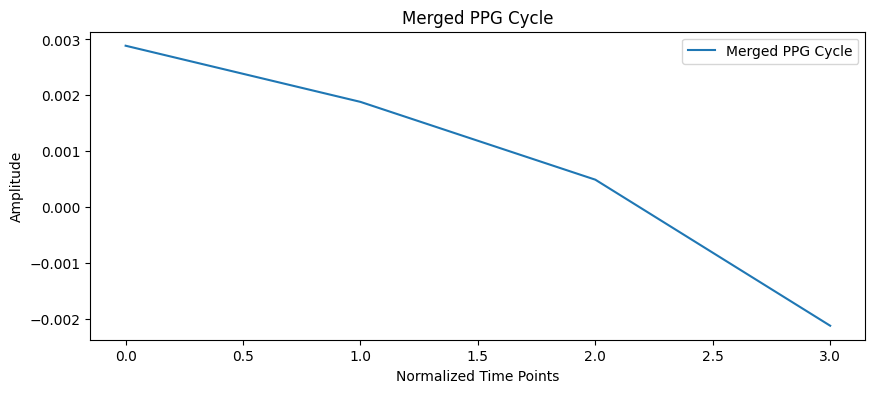

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt

def remove_baseline_wander(signal, fs, cutoff=0.5, order=2):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal



def normalize_amplitude(cycles):
    # Normalize the amplitude of cycles to have the same scale
    max_amplitude = np.max([np.max(cycle) for cycle in cycles])
    return [cycle / max_amplitude for cycle in cycles]

def extract_cycles(signal, valid_cycles):
    extracted_cycles = [signal[start:end] for start, end in valid_cycles]
    return extracted_cycles

def normalize_and_merge_cycles(cycles, target_length):
    normalized_cycles = []
    for cycle in normalize_amplitude(cycles):  # Normalize amplitude before interpolation
        x_old = np.linspace(0, 1, len(cycle))
        f = interp1d(x_old, cycle, kind='linear')
        x_new = np.linspace(0, 1, target_length)
        normalized_cycle = f(x_new)
        normalized_cycles.append(normalized_cycle)
    merged_cycle = np.mean(np.vstack(normalized_cycles), axis=0)
    return merged_cycle

# Preprocess the signal to remove baseline wander
avg_signal_corrected = remove_baseline_wander(avg_signal, fs=fps, cutoff=0.5)
# avg_signal_corrected = remove_baseline_wander(avg_signal, fs=fps)

# Extract cycles from the corrected signal
extracted_cycles = extract_cycles(avg_signal_corrected, valid_cycles)

# Define the target length for the normalized cycles
average_cycle_length = np.median([end - start for start, end in valid_cycles])  # Using median to avoid outliers
merged_cycle = normalize_and_merge_cycles(extracted_cycles, int(average_cycle_length))

# Plot the merged cycle
plt.figure(figsize=(10, 4))
plt.plot(merged_cycle, label='Merged PPG Cycle')
plt.title('Merged PPG Cycle')
plt.xlabel('Normalized Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [ ]:
valid_cycles

[(4, 6),
 (7, 10),
 (17, 23),
 (26, 28),
 (36, 44),
 (48, 51),
 (63, 67),
 (69, 70),
 (75, 78),
 (79, 81),
 (85, 93),
 (97, 101),
 (110, 117),
 (122, 126),
 (128, 131),
 (132, 136),
 (137, 139),
 (140, 144),
 (153, 160),
 (164, 166),
 (169, 173),
 (176, 190),
 (197, 206),
 (211, 213),
 (218, 221),
 (222, 229)]